<a href="https://colab.research.google.com/github/koleshjr/Fake_News_Classification/blob/main/Climate_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




## CLIMATE DATA EDA
* Can you recognize which content on Climate change is true? 
* Based on this dataset: https://www.sustainablefinance.uzh.ch/en/research/climate-fever.html

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install transformers 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import string
import re

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import f1_score, accuracy_score

from wordcloud import WordCloud, STOPWORDS
from collections import Counter, defaultdict
from PIL import Image

import spacy
import en_core_web_sm

import random
import warnings
warnings.filterwarnings('ignore')
import time
import datetime

from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler


stop = set(stopwords.words('english'))
plt.style.use('fivethirtyeight')
sns.set(font_scale=1.5)


seed_val =42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


### Loading the Datasets

In [ ]:
from pathlib import Path
path = '/content/gdrive/MyDrive/fake_news_classifier/'

df = pd.read_csv(path + 'climate-fever.csv')

display( df.head(), df.shape)



,claim_id,claim,claim_label,evidences/0/evidence_id,evidences/0/evidence_label,evidences/0/article,evidences/0/evidence,evidences/0/entropy,evidences/0/votes/0,evidences/0/votes/1,...,evidences/4/evidence_id,evidences/4/evidence_label,evidences/4/article,evidences/4/evidence,evidences/4/entropy,evidences/4/votes/0,evidences/4/votes/1,evidences/4/votes/2,evidences/4/votes/3,evidences/4/votes/4
0,0,Global warming is driving polar bears toward e...,SUPPORTS,Extinction risk from global warming:170,NOT_ENOUGH_INFO,Extinction risk from global warming,"""Recent Research Shows Human Activity Driving ...",0.693147,SUPPORTS,NOT_ENOUGH_INFO,...,Polar bear:1328,NOT_ENOUGH_INFO,Polar bear,"""Bear hunting caught in global warming debate"".",0.693147,SUPPORTS,NOT_ENOUGH_INFO,NaN,NaN,NaN
1,5,The sun has gone into ‘lockdown’ which could c...,SUPPORTS,Famine:386,SUPPORTS,Famine,The current consensus of the scientific commun...,0.000000,SUPPORTS,SUPPORTS,...,Winter:5,NOT_ENOUGH_INFO,Winter,"In many regions, winter is associated with sno...",0.693147,REFUTES,NOT_ENOUGH_INFO,NaN,NaN,NaN
2,6,The polar bear population has been growing.,REFUTES,Polar bear:1332,NOT_ENOUGH_INFO,Polar bear,"""Ask the experts: Are polar bear populations i...",0.693147,NOT_ENOUGH_INFO,REFUTES,...,Polar bear:61,REFUTES,Polar bear,Of the 19 recognized polar bear subpopulations...,0.000000,REFUTES,REFUTES,NaN,NaN,NaN
3,9,Ironic' study finds more CO2 has slightly cool...,REFUTES,Atmosphere of Mars:131,NOT_ENOUGH_INFO,Atmosphere of Mars,CO2 in the mesosphere acts as a cooling agent ...,0.693147,NOT_ENOUGH_INFO,SUPPORTS,...,Carbon dioxide:191,NOT_ENOUGH_INFO,Carbon dioxide,"Less energy reaches the upper atmosphere, whic...",0.000000,NOT_ENOUGH_INFO,NOT_ENOUGH_INFO,NaN,NaN,NaN
4,10,Human additions of CO2 are in the margin of er...,REFUTES,Carbon dioxide in Earth's atmosphere:140,NOT_ENOUGH_INFO,Carbon dioxide in Earth's atmosphere,While CO 2 absorption and release is always ha...,0.693147,NOT_ENOUGH_INFO,REFUTES,...,Sea:226,REFUTES,Sea,"More recently, anthropogenic activities have s...",0.000000,REFUTES,REFUTES,NaN,NaN,NaN


(1535, 53)

In [ ]:
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

def preprocess(df,id_col, text_col, target_col ):
    # Rename columns if necessary
    if text_col != 'inputs':
        df.rename(columns={text_col: 'inputs'}, inplace=True)
    if target_col != 'target':
        df.rename(columns={target_col: 'target'}, inplace=True)
    if id_col != 'id':
        df.rename(columns={id_col: 'id'}, inplace=True)

    
    # Remove URLs, HTML tags, and emojis
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    html_pattern = re.compile('<.*?>')
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    
    df['inputs'] = df['inputs'].apply(lambda x: url_pattern.sub('', x))
    df['inputs'] = df['inputs'].apply(lambda x: html_pattern.sub('', x))
    df['inputs'] = df['inputs'].apply(lambda x: emoji_pattern.sub('', x))
    
    # Remove punctuation and convert to lowercase
    table = str.maketrans('', '', string.punctuation)
    df['clean_inputs'] = df['inputs'].apply(lambda x: x.translate(table))
    df['clean_inputs'] = df['clean_inputs'].apply(lambda x: x.lower())
    
    # Tokenize and remove stop words
    nltk.download('punkt')
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))
    df['tokenized'] = df['clean_inputs'].apply(lambda x: word_tokenize(x))
    df['lower'] = df['tokenized'].apply(lambda x: [word.lower() for word in x])
    df['stops_removed'] = df['lower'].apply(lambda x: [word for word in x if word not in stop_words])
    
    # Add POS tags and convert to WordNet POS tags
    nltk.download('averaged_perceptron_tagger')
    df['pos_tags'] = df['stops_removed'].apply(lambda x: nltk.pos_tag(x))
    df['wordnet_pos'] = df['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
    
    # Lemmatize and remove stop words again
    nltk.download('wordnet')
    lemmatizer = WordNetLemmatizer()
    df['lemmatized'] = df['wordnet_pos'].apply(lambda x: [lemmatizer.lemmatize(word, pos=pos_tag) for (word, pos_tag) in x])
    df['lemma_str'] = df['lemmatized'].apply(lambda x: ' '.join([word for word in x if word not in stop_words]))
    df['Character Count'] = df['lemma_str'].apply(lambda x: len(str(x)))
    
    # Drop intermediate columns
    df = df.loc[:, ['id', 'inputs', 'lemma_str', 'target','Character Count','lemmatized']]    
    return df

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


df = preprocess(df, 'claim_id','claim','claim_label')
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,id,inputs,lemma_str,target,Character Count,lemmatized
0,0,Global warming is driving polar bears toward e...,global warm drive polar bear toward extinction,SUPPORTS,46,"[global, warm, drive, polar, bear, toward, ext..."
1,5,The sun has gone into ‘lockdown’ which could c...,sun go ‘ lockdown ’ could cause freeze weather...,SUPPORTS,79,"[sun, go, ‘, lockdown, ’, could, cause, freeze..."
2,6,The polar bear population has been growing.,polar bear population grow,REFUTES,26,"[polar, bear, population, grow]"
3,9,Ironic' study finds more CO2 has slightly cool...,ironic study find co2 slightly cool planet,REFUTES,42,"[ironic, study, find, co2, slightly, cool, pla..."
4,10,Human additions of CO2 are in the margin of er...,human addition co2 margin error current measur...,REFUTES,126,"[human, addition, co2, margin, error, current,..."


Target value_counts

In [ ]:
df['target'].value_counts()

SUPPORTS           654
NOT_ENOUGH_INFO    474
REFUTES            253
DISPUTED           154
Name: target, dtype: int64

### Data Visualization

#### Target Visualization

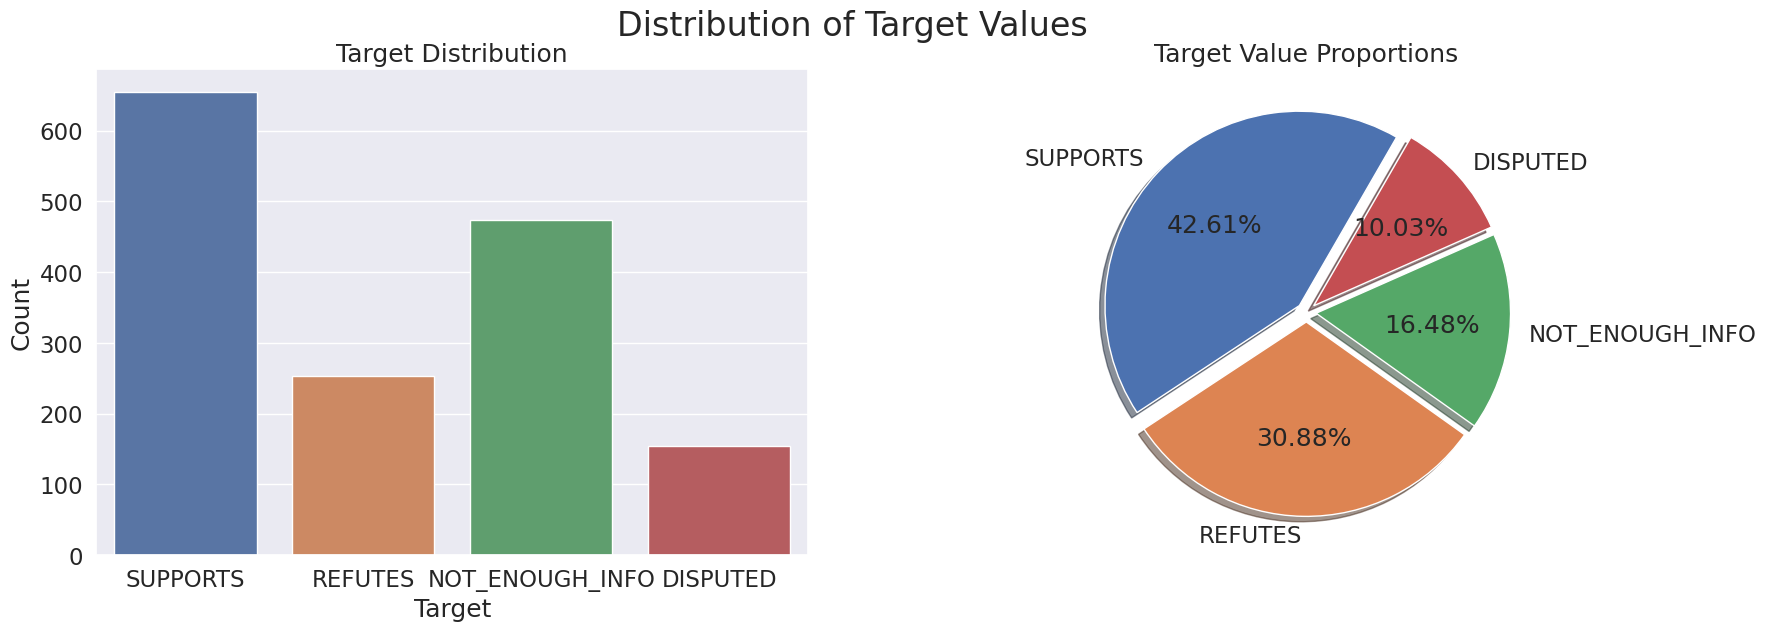

In [ ]:
def plot_target_distribution(df, target_col, label_dict=None, figsize=(18, 6)):
    # If label_dict is not provided, create a mapping based on unique target values
    if label_dict is None:
        label_dict = {i: val for i, val in enumerate(df[target_col].unique())}

    # Create a figure with two subplots
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=figsize, dpi=100)

    # Plot a countplot of target values on the first subplot
    sns.countplot(x=target_col, data=df, ax=axes[0])
    axes[0].set_xticklabels(label_dict.values())
    axes[0].set_xlabel('Target')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Target Distribution')

    # Plot a pie chart of target value proportions on the second subplot
    axes[1].pie(df[target_col].value_counts(),
                labels=label_dict.values(),
                autopct='%1.2f%%',
                shadow=True,
                explode=[0.05]*len(label_dict),
                startangle=60)
    axes[1].set_title('Target Value Proportions')

    # Add a suptitle to the figure
    fig.suptitle('Distribution of Target Values', fontsize=24)

    # Show the plot
    plt.show()

plot_target_distribution(df, 'target')


#### Inputs Lengths

In [ ]:
df.head()

,id,inputs,lemma_str,target,Character Count,lemmatized
0,0,Global warming is driving polar bears toward e...,global warm drive polar bear toward extinction,SUPPORTS,46,"[global, warm, drive, polar, bear, toward, ext..."
1,5,The sun has gone into ‘lockdown’ which could c...,sun go ‘ lockdown ’ could cause freeze weather...,SUPPORTS,79,"[sun, go, ‘, lockdown, ’, could, cause, freeze..."
2,6,The polar bear population has been growing.,polar bear population grow,REFUTES,26,"[polar, bear, population, grow]"
3,9,Ironic' study finds more CO2 has slightly cool...,ironic study find co2 slightly cool planet,REFUTES,42,"[ironic, study, find, co2, slightly, cool, pla..."
4,10,Human additions of CO2 are in the margin of er...,human addition co2 margin error current measur...,REFUTES,126,"[human, addition, co2, margin, error, current,..."


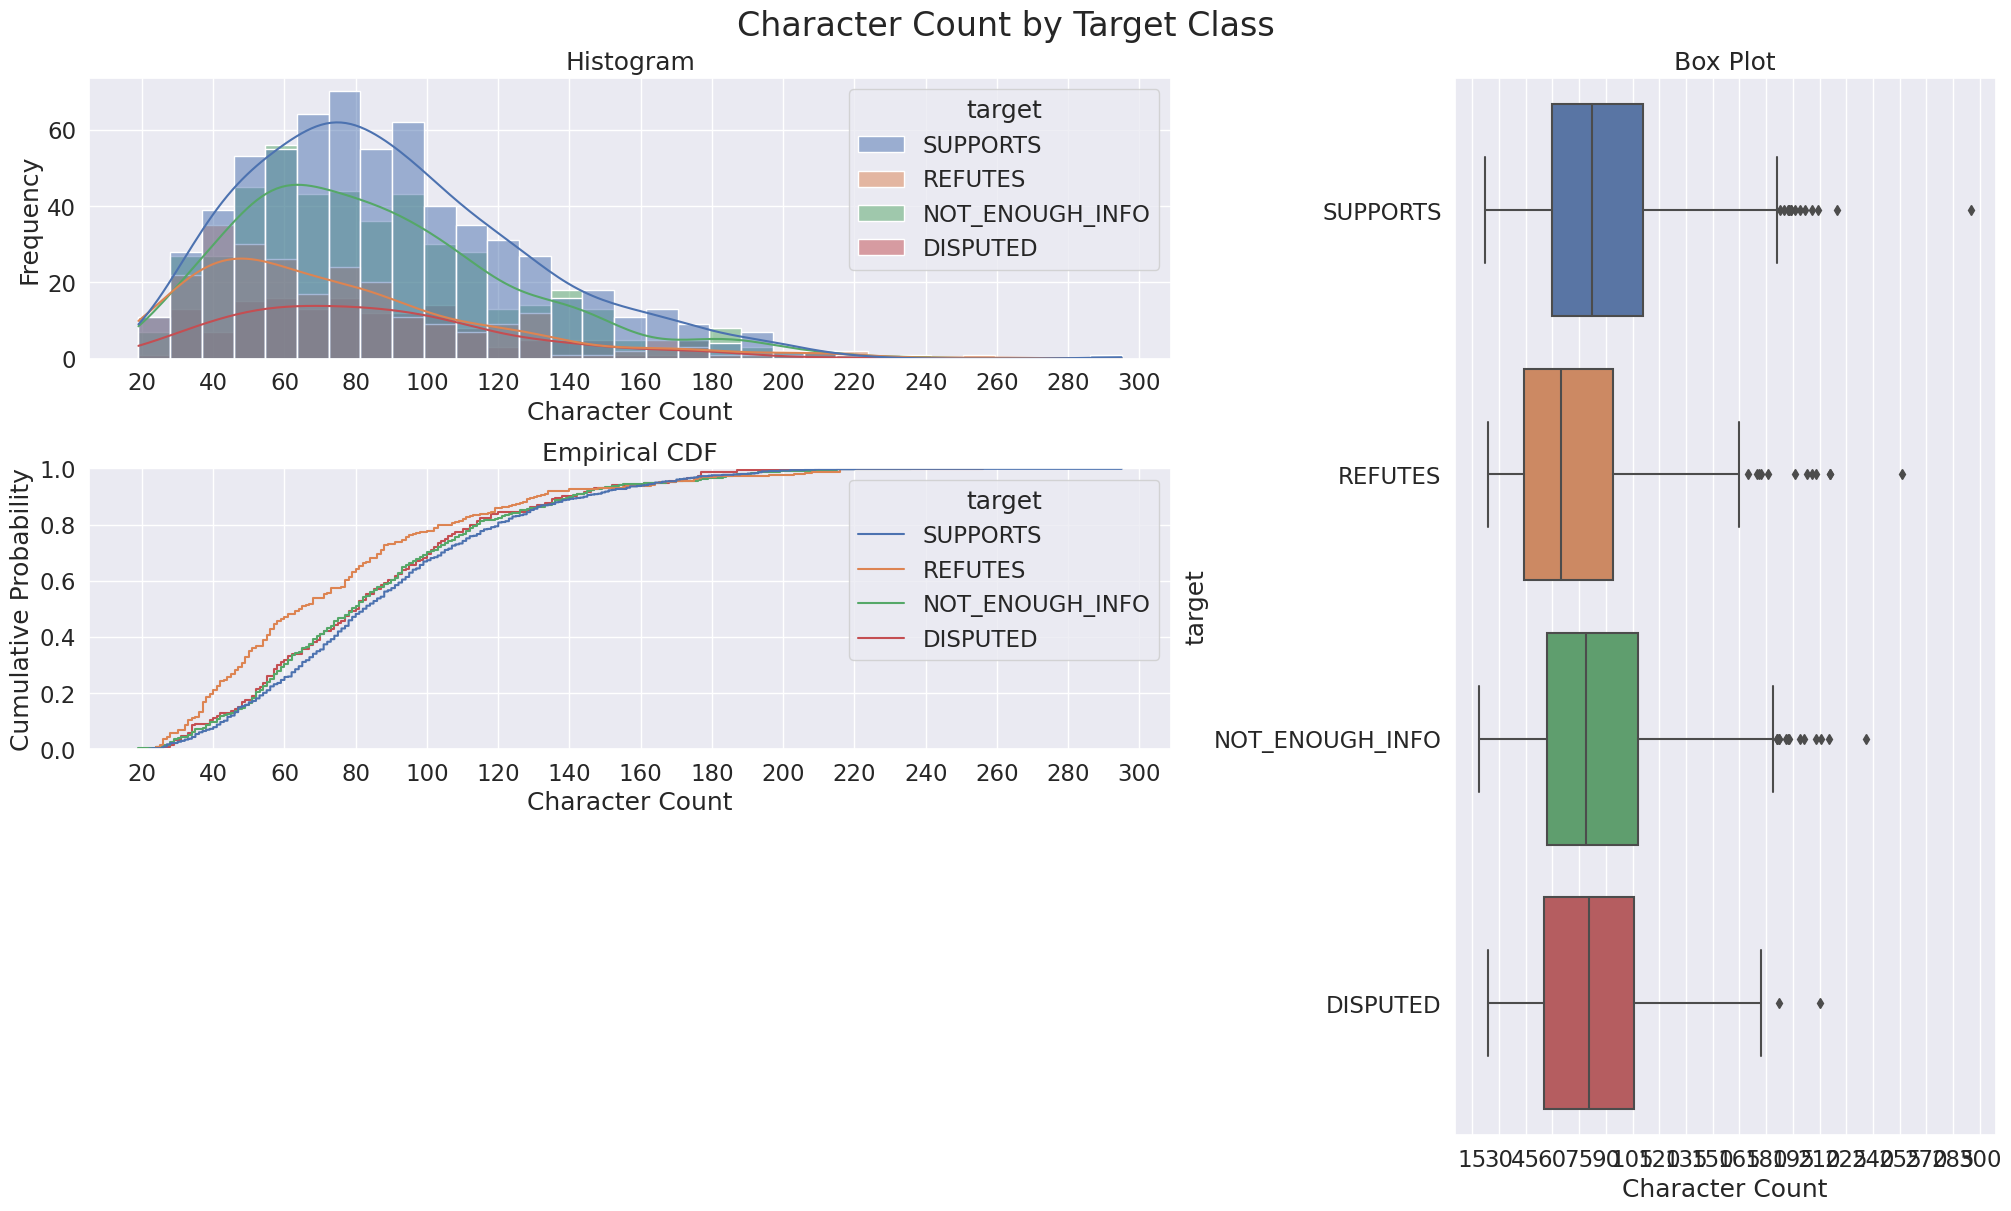

In [ ]:
# Function to plot distribution of character count by target class
def plot_dist3(df, target_col, text_col, title):
    # Creating a customized chart. and giving in figsize and everything.
    fig = plt.figure(constrained_layout=True, figsize=(20, 12))
    # Creating a grid of 3 cols and 3 rows.
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    # Customizing the histogram grid.
    ax1 = fig.add_subplot(grid[0, :2])
    # Set the title.
    ax1.set_title('Histogram')
    # plot the histogram.
    sns.histplot(df, x='Character Count', hue=target_col, kde=True, ax=ax1)
    ax1.set(ylabel='Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))

    # Customizing the ecdf_plot.
    ax2 = fig.add_subplot(grid[1, :2])
    # Set the title.
    ax2.set_title('Empirical CDF')
    # Plotting the ecdf_Plot.
    sns.ecdfplot(df, x='Character Count', hue=target_col, ax=ax2)
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=20))
    ax2.set(ylabel='Cumulative Probability')

    # Customizing the Box Plot.
    ax3 = fig.add_subplot(grid[:, 2])
    # Set title.
    ax3.set_title('Box Plot')
    # Plotting the box plot.
    sns.boxplot(x='Character Count', y=target_col, data=df, orient='h', ax=ax3)
    ax3.xaxis.set_major_locator(MaxNLocator(nbins=25))

    plt.suptitle(f'{title}', fontsize=24)
    
# Call the function with the sample data
plot_dist3(df, target_col='target', text_col='inputs', title='Character Count by Target Class')

#### Word Count

In [ ]:
def plot_word_number_histogram(df, text_col, target_col):

    """A function for comparing word counts"""

    fig, axes = plt.subplots(ncols=len(df[target_col].unique()), nrows=1, figsize=(18, 6), sharey=True)
    colors = ['#e74c3c', '#3498db', '#2ecc71', '#f1c40f', '#9b59b6', '#34495e', '#95a5a6', '#1abc9c', '#16a085']
    labels = df[target_col].unique()
    for i, label in enumerate(labels):
        sns.distplot(df[df[target_col]==label][text_col].str.split().map(lambda x: len(x)), ax=axes[i], color=colors[i % len(colors)])
        axes[i].set_xlabel('Word Count')
        axes[i].set_title(label)

    fig.suptitle('Words Per ' + text_col.capitalize(), fontsize=24, va='baseline')

    fig.tight_layout()


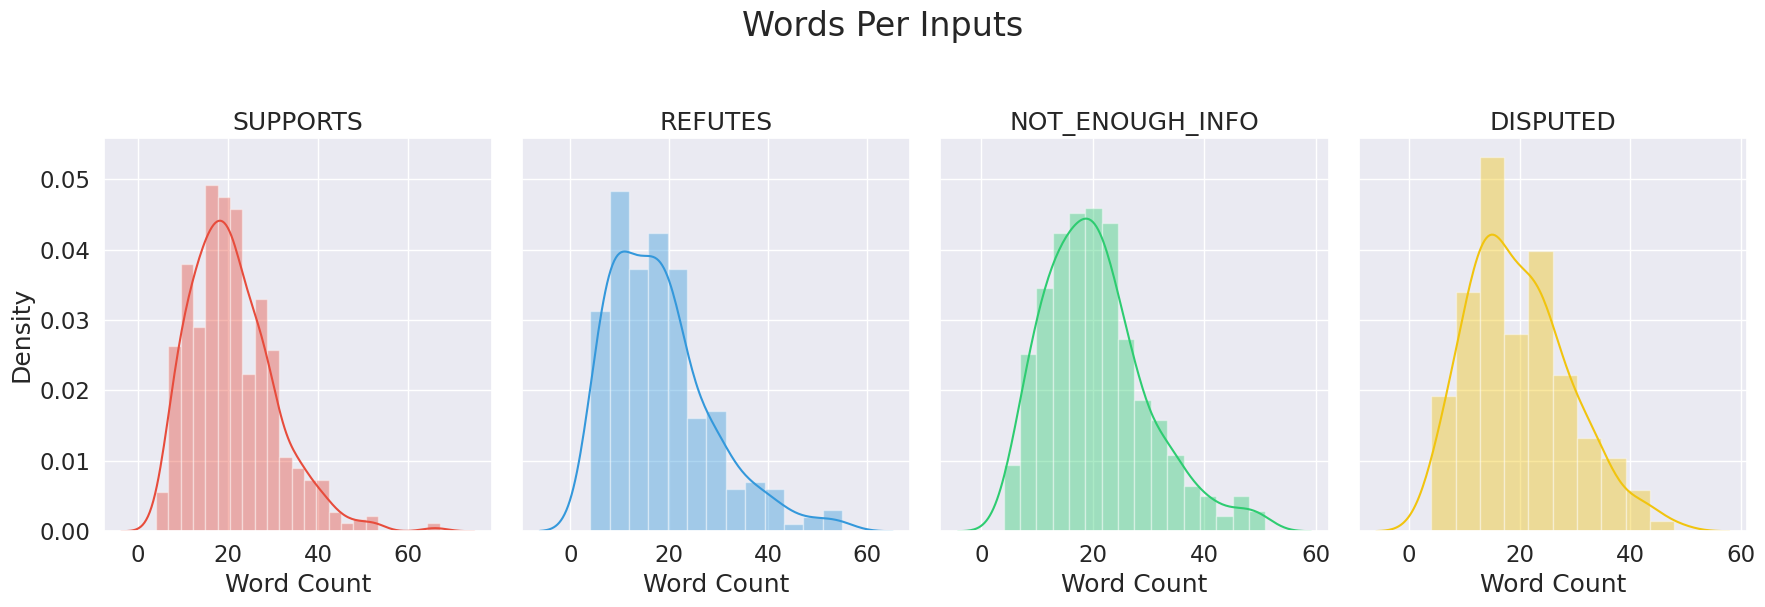

In [ ]:
plot_word_number_histogram(df, 'inputs','target')

#### Word length

In [ ]:
def plot_word_len_histogram(df, text_col, target_col):
    '''Function to plot word length histograms for a given text column and target column in a pandas dataframe'''

    # Create subplots
    fig, axes = plt.subplots(ncols=len(df[target_col].unique()), nrows=1, figsize=(18, 6), sharey=True)
    colors = ['#e74c3c', '#3498db', '#2ecc71', '#f1c40f', '#9b59b6', '#34495e', '#95a5a6', '#1abc9c', '#16a085']

    # Iterate over unique target values and plot histograms
    for i, target in enumerate(df[target_col].unique()):
        sns.distplot(df[df[target_col]==target][text_col].str.split().apply(lambda x: [len(i) for i in x]).map(lambda x: np.mean(x)),
                    ax=axes[i] , color=colors[i % len(colors)])
        axes[i].set_xlabel('Word Length')
        axes[i].set_ylabel('Frequency')
        axes[i].set_title(target)

    fig.suptitle('Mean Word Lengths by Target', fontsize=24, va='baseline')
    fig.tight_layout()


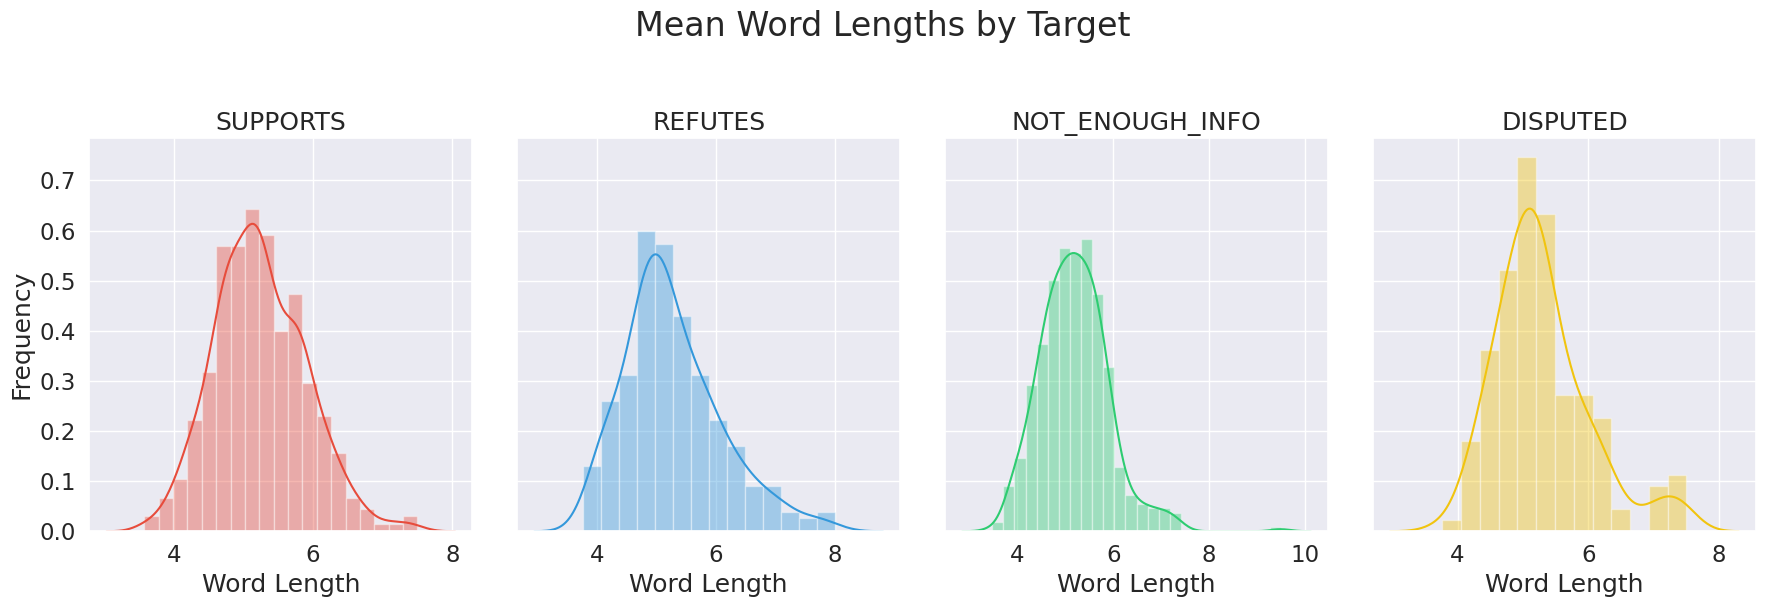

In [ ]:
plot_word_len_histogram(df, 'inputs', 'target')

#### Most Common Ngrams

In [ ]:
df['target'].value_counts()

SUPPORTS           654
NOT_ENOUGH_INFO    474
REFUTES            253
DISPUTED           154
Name: target, dtype: int64

In [ ]:
from collections import Counter
import seaborn as sns

def plot_common_ngrams(df, text_col, target_col, ngrams=2):
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    axes = axes.flatten()
    for target, ax in zip(df[target_col].unique(), axes):
        corpus = df.loc[df[target_col] == target, text_col].str.split().tolist()
        n_grams = [ngram for sublist in corpus for ngram in zip(*[sublist[i:] for i in range(ngrams)])]
        counter = Counter(n_grams)
        most_common = counter.most_common(30)
        n_gram, count = zip(*most_common)
        sns.barplot(x=list(count), y=list(map(lambda x: ' '.join(x), n_gram)), ax=ax, palette='plasma')
        ax.set_title(f'Most Common {ngrams}-grams - Target {target}')
        ax.set_xlabel('Count')
        ax.set_ylabel(f'{ngrams}-gram')
    fig.suptitle(f'Most Common {ngrams}-grams', fontsize=24, va='baseline')
    plt.tight_layout()


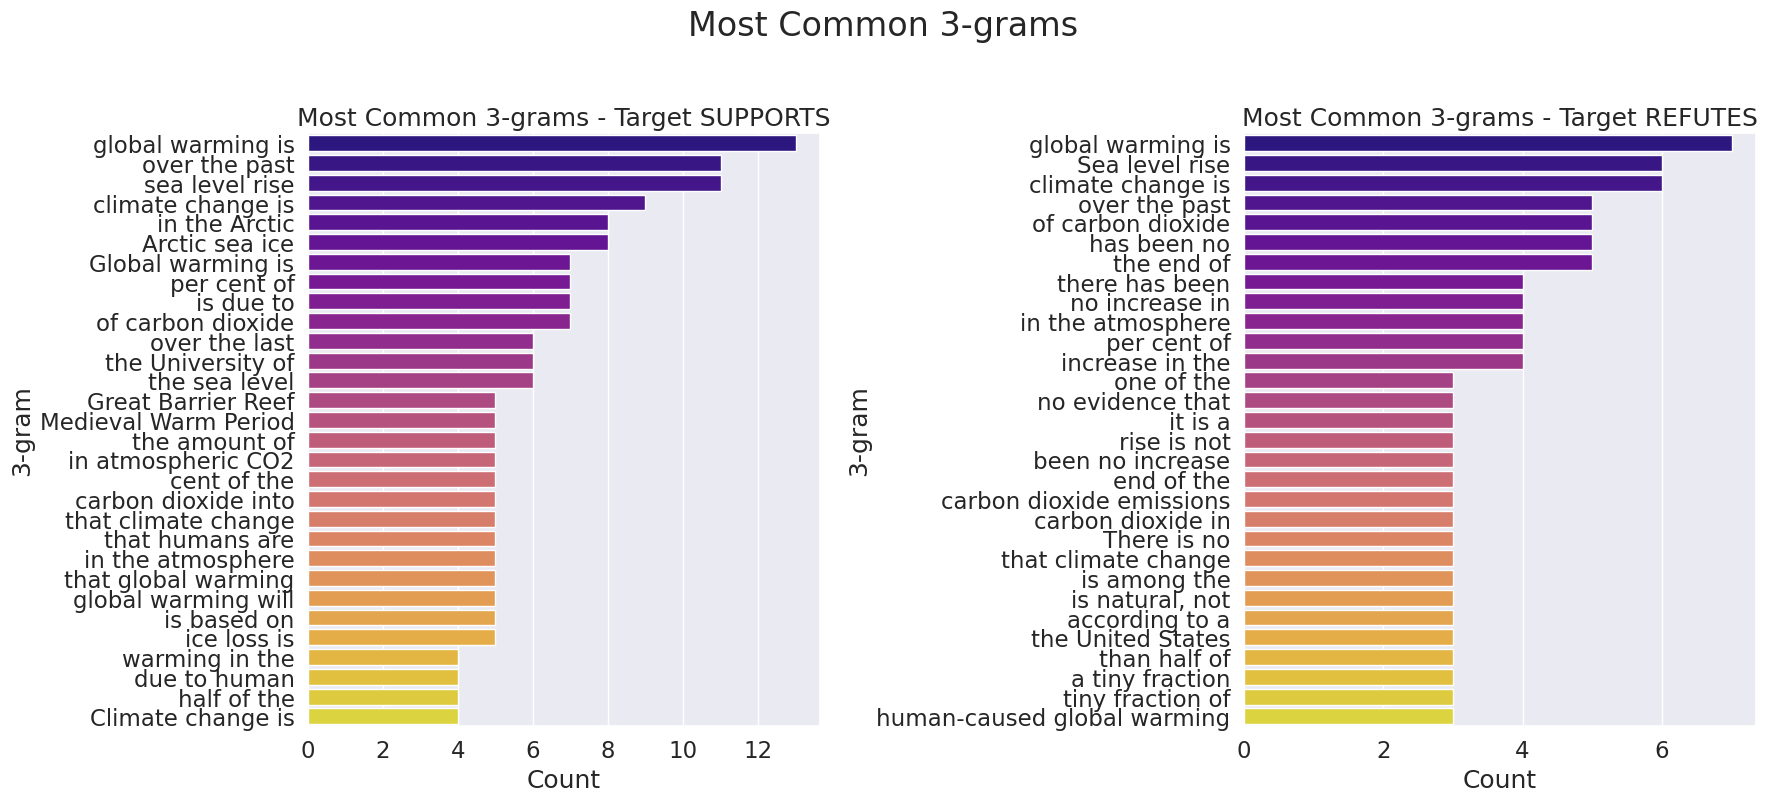

In [ ]:
plot_common_ngrams(df, 'inputs','target', 3)

### Word Cloud

In [ ]:
import random
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from nltk.probability import FreqDist

def plot_wordcloud(df, target_col, text_col, title, title_size):
    """A function for creating wordcloud images based on lemmatized text inputs of a multi-class dataframe."""
    fig, axes = plt.subplots(1, len(df[target_col].unique()), figsize=(18, 6))
    axes = axes.flatten()
    for target, ax in zip(df[target_col].unique(), axes):
        words = df.loc[df[target_col] == target, text_col].tolist()
        allwords = []
        for wordlist in words:
            allwords += wordlist
        mostcommon = FreqDist(allwords).most_common(140)
        wordcloud = WordCloud(
            width=1200,
            height=800,
            background_color='black',
            stopwords=set(STOPWORDS),
            max_words=150,
            scale=3,
            contour_width=0.1,
            contour_color='grey',
        ).generate_from_frequencies(dict(mostcommon))

        def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
            """A definition for creating grey color shades."""
            return 'hsl(0, 0%%, %d%%)' % random.randint(60, 100)

        ax.imshow(wordcloud.recolor(color_func=grey_color_func, random_state=42),
                   interpolation='bilinear')
        ax.set_axis_off()
        ax.set_title(f'Target {target}', fontdict={'size': 20, 'verticalalignment': 'bottom'})
    fig.suptitle(title, fontsize=title_size, va='baseline')
    plt.tight_layout()
    plt.show()


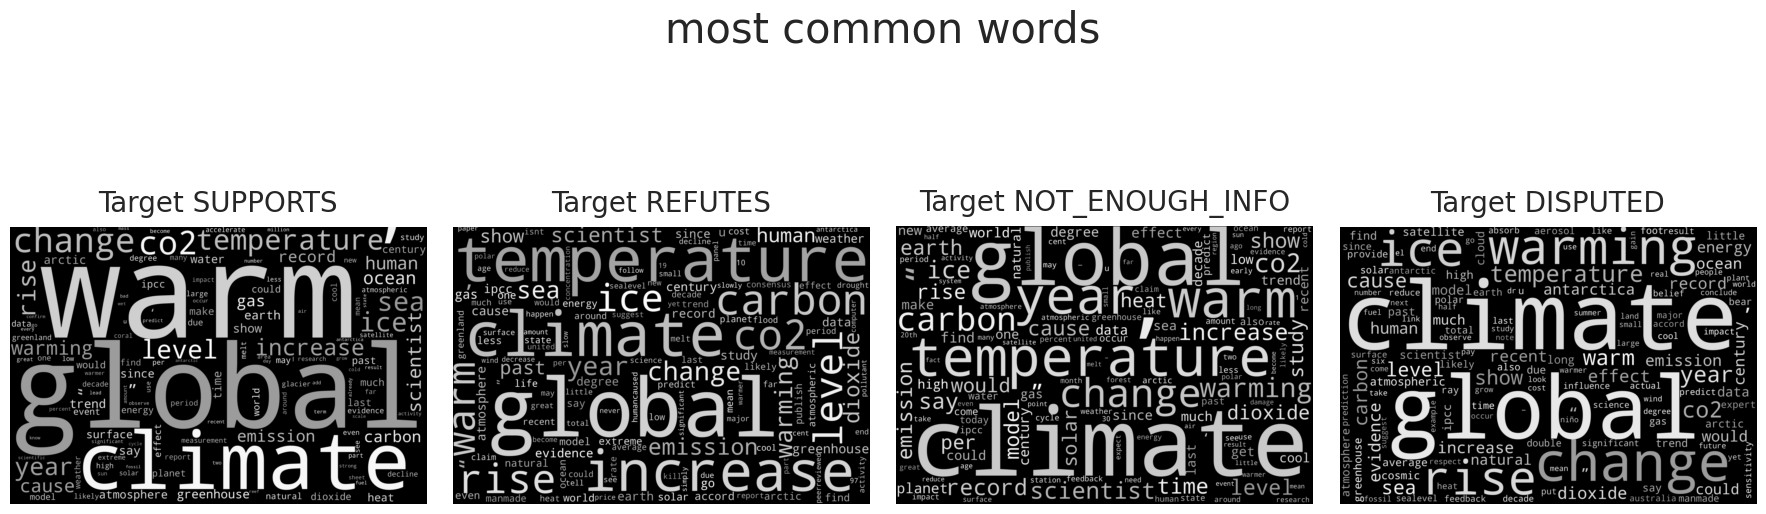

In [ ]:
plot_wordcloud(df, 'target', 'lemmatized', 'most common words', 30)

#### Named Entity Recognition

In [ ]:
# Loading NER.
nlp = en_core_web_sm.load() 

In [ ]:
def plot_named_entity_barchart(text):
    
    """A function for extracting named entities and comparing them"""
    
    def _get_ner(text):
        doc = nlp(text)
        return [X.label_ for X in doc.ents]

    ent = text.apply(lambda x: _get_ner(x))
    ent = [x for sub in ent for x in sub]
    counter = Counter(ent)
    count = counter.most_common()

    x, y = map(list, zip(*count))
    sns.barplot(x=y, y=x)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import Counter
import en_core_web_sm


def plot_named_entity_barchart(df, target_col, text_col):
    """A function for extracting named entities and comparing them across target categories"""
    nlp = en_core_web_sm.load()
    categories = df[target_col].unique()
    n_categories = len(categories)
    fig, axes = plt.subplots(1, n_categories, figsize=(5*n_categories, 8))
    axes = axes.flatten()
    
    for i, category in enumerate(categories):
        subset = df.loc[df[target_col] == category, text_col]
        
        def _get_ner(text):
            doc = nlp(text)
            return [X.label_ for X in doc.ents]

        ent = subset.apply(lambda x: _get_ner(x))
        ent = [x for sub in ent for x in sub]
        counter = Counter(ent)
        count = counter.most_common()[:15]

        x, y = map(list, zip(*count))
        sns.barplot(x=y, y=x, ax=axes[i], palette='plasma')
        axes[i].set_title(f"{target_col} = {category}")
        axes[i].set_xlabel('Count')
        axes[i].set_ylabel('Named-Entity')

    fig.suptitle('Common Named-Entity Counts', fontsize=24, va='baseline')

    patch1 = mpatches.Patch(label='PERSON : People, including fictional')
    patch2 = mpatches.Patch(label='ORG : Companies, agencies, institutions, etc.')
    patch3 = mpatches.Patch(label='CARDINAL : Numerals that dont fall under another type.')
    patch4 = mpatches.Patch(label='GPE : Countries, cities, states.')
    patch5 = mpatches.Patch(label='NORP : Nationalities or religious or political groups.')
    patch6 = mpatches.Patch(label='TIME : Times smaller than a day.')
    patch7 = mpatches.Patch(label='QUANTITY : Measurements, as of weight or distance.')
    patch8 = mpatches.Patch(label='ORDINAL : “first”, “second”, etc.')
    patch9 = mpatches.Patch(label='LOC : Non-GPE locations, mountain ranges, bodies of water.')
    patch10 = mpatches.Patch(label='FAC : Buildings, airports, highways, bridges, etc.')
    patch11 = mpatches.Patch(label='PRODUCT : Objects, vehicles, foods, etc. (Not services.)')
    patch12 = mpatches.Patch(label='EVENT : Named hurricanes, battles, wars, sports events, etc.')
    patch13 = mpatches.Patch(label='LANGUAGE : Any named language.')
    patch14 = mpatches.Patch(label='PERCENT : Percentage, including ”%“.')
    patch15 = mpatches.Patch(label='DATE : Absolute or relative dates or periods.')

    plt.legend(handles=[patch1, patch2, patch3, patch4, patch5, patch6, patch7, patch8, patch9, patch10, patch11, patch12, patch13, patch14, patch15, ],
               bbox_to_anchor=(1.05, 0.85), loc='upper left', borderaxespad=0.)

    plt.show()


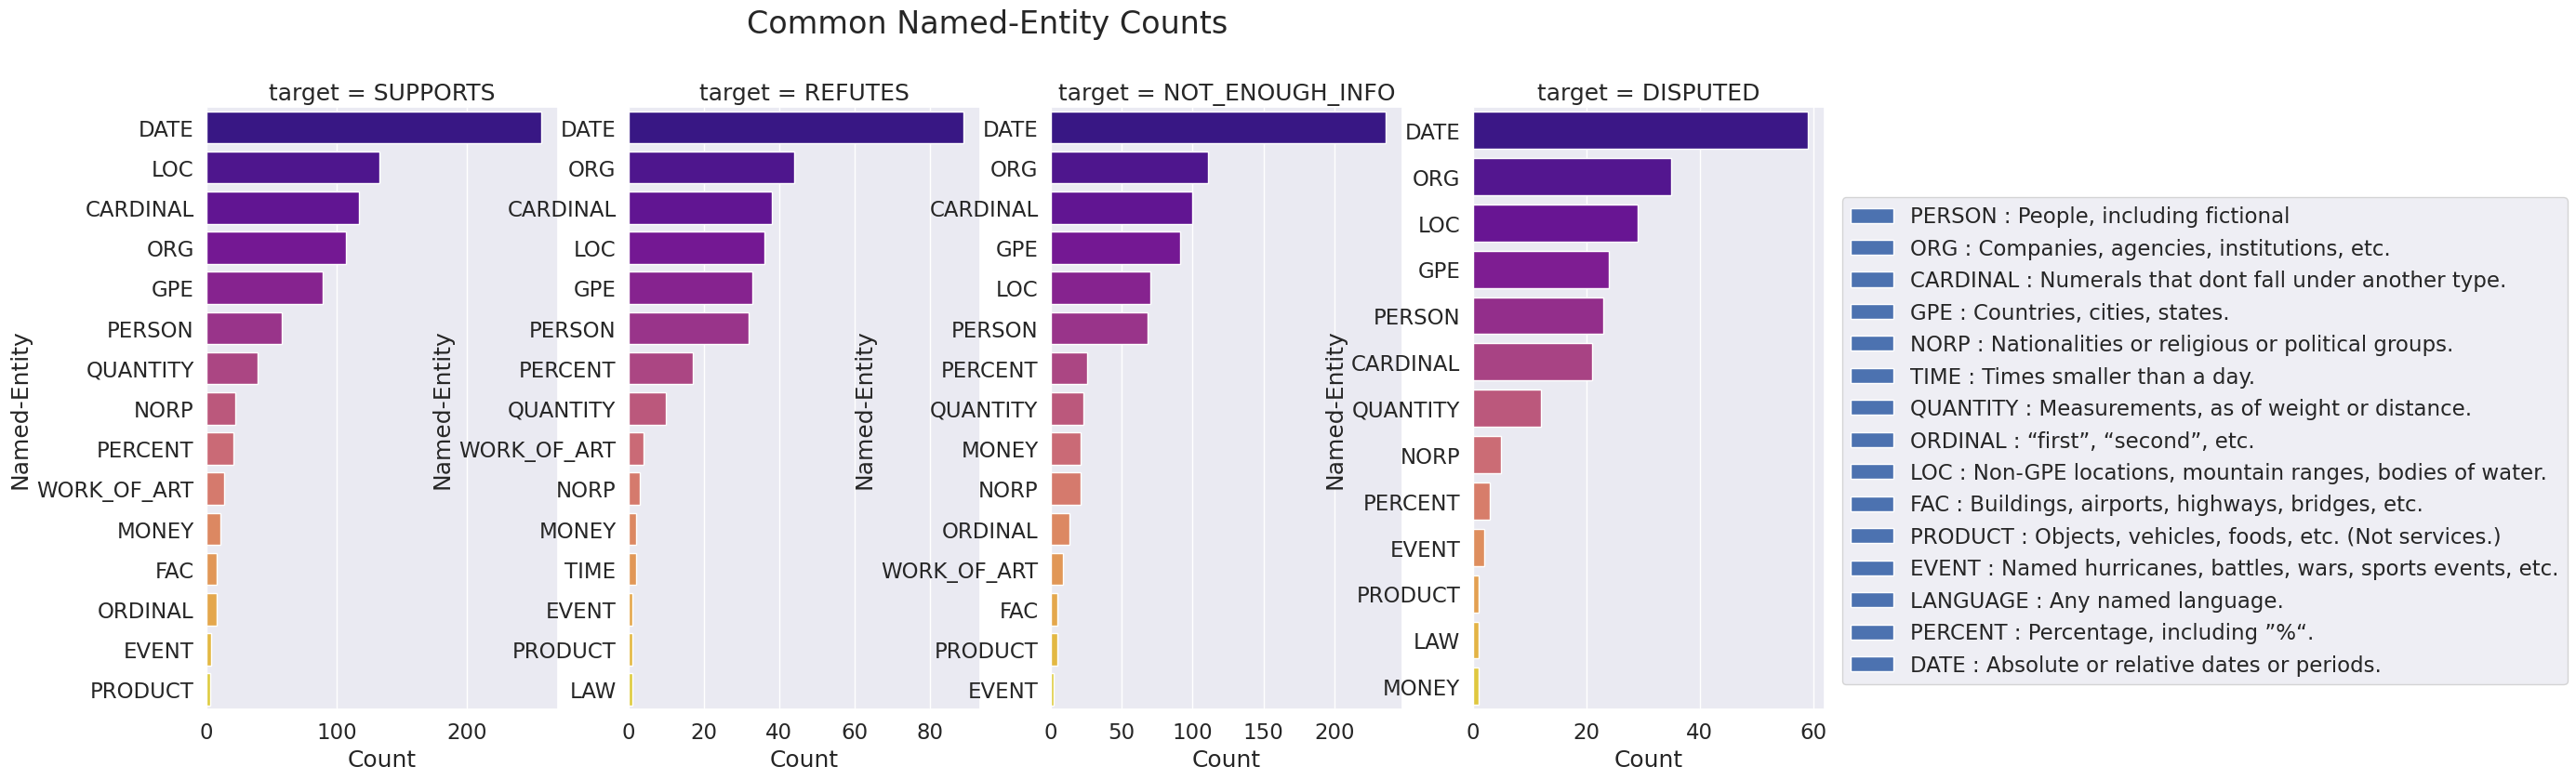

In [ ]:
plot_named_entity_barchart(df, 'target', 'inputs')


In [ ]:
!pip freeze > path + 'requirements.txt'